#### TRANSFER LEARNING

Using Transfer learning to import Custom pretrained models for performance comparism with our custom model for any improvement

#### EfficientNetB0 Pretrained model

In [1]:
# Importing our model with necessary libraries
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
# Defining our custom colors
filterwarnings('ignore')
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

#### Specifying our Image data Paths

In [2]:
train_path = "C:/Users/Franks/Desktop/APPLIED AI 3_4_2023/Training" 
test_path = "C:/Users/Franks/Desktop/APPLIED AI 3_4_2023/Testing"

Defining Our output Labels

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

Appending images from the directories into a Python list and then converting them into numpy arrays after resizing it.

In [4]:
X_train = []
y_train = []
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join(train_path,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

In [5]:
for i in labels:
    folderPath = os.path.join(test_path,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

In [6]:
# converting them into numpy arrays after resizing.
X_train = np.array(X_train)
y_train = np.array(y_train)

Reshuffling the training data to prevent any sytematic orderings that can affect the training process

In [7]:
# reshuffle the train data with a random state of 101
X_train,y_train = shuffle(X_train,y_train,random_state=101)

In [8]:
# Checking the shape
X_train.shape

(3264, 150, 150, 3)

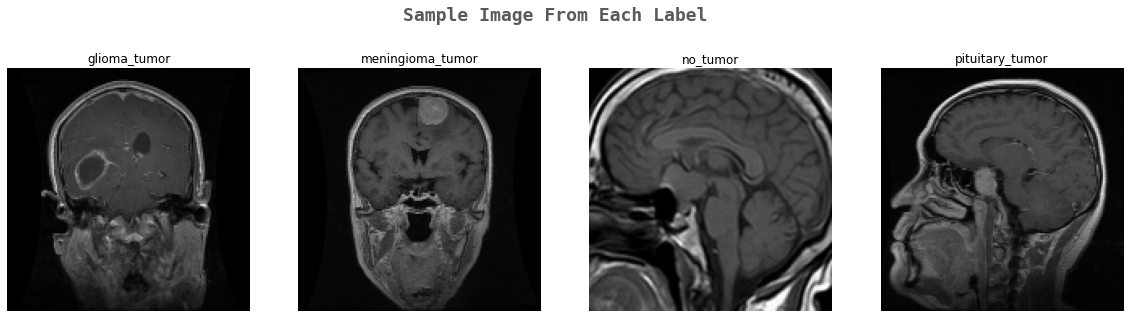

In [9]:
# Sampling the shapes from each label
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

#### Performing our train test split

In [10]:
X_train.shape

(3264, 150, 150, 3)

In [11]:
# Splitting our dataset
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.1,random_state=101)

Performing One Hot Encoding on the labels after converting them into numerical values:

In [12]:
# one hot encoding on the train data
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [13]:
# one hot encoding on the train data
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

#### Importing and defining our EfficientNet model using transfer learning

EfficientNetB0 Pretrained model

In [14]:
# Importing our model
from tensorflow.keras.applications import EfficientNetB0
from warnings import filterwarnings

#### Constructor Stage

In [15]:
# defining our Model
# load pre-trained EfficientNet model without the top layer 
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

Making use of GlobalAveragePooling2D layer in place of Max pooling layer by using average values instead of Max values

In [16]:
# Adjusting the output dense layers of the EfficientNet model to customise it to our task 
effnet_model = effnet.output
effnet_model = tf.keras.layers.GlobalAveragePooling2D()(effnet_model)
effnet_model = tf.keras.layers.Dropout(rate=0.5)(effnet_model)
effnet_model = tf.keras.layers.Dense(4,activation='softmax')(effnet_model)
effnet_model = tf.keras.models.Model(inputs=effnet.input, outputs = effnet_model)

In [17]:
effnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

 block2b_expand_conv (Conv2D)   (None, 38, 38, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 38, 38, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 38, 38, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 38, 38, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
          

                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 19, 19, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 19, 19, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 19, 19, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_s

 block4b_activation (Activation  (None, 10, 10, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_s

                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 10, 10, 480)  0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_p

 block5c_project_conv (Conv2D)  (None, 10, 10, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 10, 10, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 10, 10, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 10, 10, 112)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block6a_e

 block6b_add (Add)              (None, 5, 5, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 5, 5, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 5, 5, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 5, 5, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block7a_expand_bn (BatchNormal  (None, 5, 5, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 5, 5, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 5, 5, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 5, 5, 1152)  4608        ['block7a_dwconv[0][0]']         
 )        

#### Compilation Stage

In [18]:
# compile our model 
effnet_model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

Callbacks help you visualize the progress of model training and help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration

In [19]:
# using TensorBoard, ModelCheckpoint and ReduceLROnPlateau callback functions
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

#### Training stage

In [20]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [29]:
effnet_hist = effnet_model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])
X_train.shape

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.8256
Epoch 1: val_accuracy improved from -inf to 0.86395, saving model to effnet.h5
83/83 [==============================] - 276s 3s/step - loss: 0.4825 - accuracy: 0.8256 - val_loss: 0.5404 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9285
Epoch 2: val_accuracy improved from 0.86395 to 0.87755, saving model to effnet.h5
83/83 [==============================] - 273s 3s/step - loss: 0.2143 - accuracy: 0.9285 - val_loss: 0.3609 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9584
Epoch 3: val_accuracy did not improve from 0.87755
83/83 [==============================] - 285s 3s/step - loss: 0.1272 - accuracy: 0.9584 - val_loss: 0.7002 - val_accuracy: 0.8605 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0902 - 

(2937, 150, 150, 3)

#### Model Prediction

In [30]:
pred = effnet_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 8s 730ms/step


#### Model Evaluation

In [31]:
# print(classification_report(y_test_new,pred))
print(classification_report(y_test_new, pred, target_names = ['glioma_tumor', 'meningioma_tumor','no_tumor', 'pituitary_tumor' ]))

                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.96      0.96        93
meningioma_tumor       0.96      0.97      0.96        95
        no_tumor       1.00      0.98      0.99        52
 pituitary_tumor       0.99      1.00      0.99        87

        accuracy                           0.98       327
       macro avg       0.98      0.98      0.98       327
    weighted avg       0.98      0.98      0.98       327



In [32]:
# confusion matrix takes both actual value and predicted value
cm = confusion_matrix(y_test_new, pred)

In [33]:
cm

array([[89,  4,  0,  0],
       [ 2, 92,  0,  1],
       [ 1,  0, 51,  0],
       [ 0,  0,  0, 87]], dtype=int64)

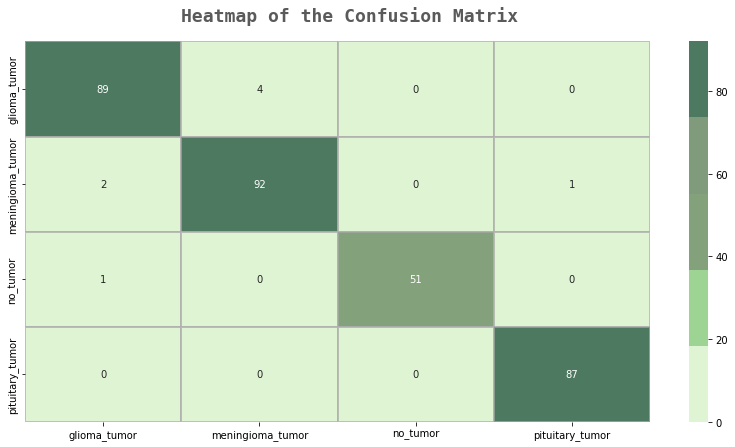

In [35]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()